# Example: Physics-Infused Models - Part 2/2

- Author: Dr. Daning Huang
- Date: 11/09/2025
- Updated: 12/08/2025

## Problem

Continuing the example, we consider an augmented pendulum problem with an input $u$,

$$
\begin{aligned}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= - \frac{g}{l}\left( \sin(x_1) + \frac{1}{10} s + u \right) \\
\dot{s} &= -5s + x_1
\end{aligned}\quad\text{or}\quad \dot{z} = F(z,u,p)
$$

where augmented state $z=[x,s]$ and the residual force is assumed to come from the output of a hidden dynamics with state $s$.  In this example, $s$ can be thought of a memory term that remembers the past $x_1$.

Now suppose we still only know the physical part of the dynamics

$$
\begin{aligned}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= - \frac{g}{l}\left( \sin(x_1) + r + u \right)
\end{aligned}\quad\text{or}\quad \dot{x} = \hat{f}(x,u,r,p)
$$

This time the residual $r$ has its own state and thus $\hat{f}$ is insufficient to close the system.  Hence we need to introduce some learnable hidden dynamics

$$
\begin{aligned}
\dot{\beta} &= h(\beta, x, u; \Theta) \\
r &= r(\beta, x, u; \Theta)
\end{aligned}
$$

Here $\beta$ is not necessarily the same as the original hidden state $s$, but the hope is that given the same "inputs" $(x, u)$, the learned dynamics produces the same "output" $r$.

Lastly, again for simplicity, since we know the true form of hidden dynamics, which is linear, we will just use linear models for $h$ and $r$.

## Case Setup

### The usuals

First, some imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import TemplateCorrDif
from dymad.training import NODETrainer
from dymad.utils import plot_multi_trajs, TrajectorySampler

Then data generation.  Note an additional `g` function that extracts only the physical states.

Here, to keep the problem clean, we assume the initial hidden state is always 0; this makes sense in the current setup, as the initial "memory" should contain nothing.  Again the parameter is fixed.

In [2]:
B = 32
N = 101
t_grid = np.linspace(0, 2, N)

gg = 9.81
def f(t, x, u, p=[1.0]):
    dtheta = x[1]
    domega = - (gg / p[0]) * (np.sin(x[0]) + 0.1 * x[2] + u[0])
    dbeta  = -5*x[2] + x[0]
    return np.array([dtheta, domega, dbeta])
def g(t, x, u, p=[1.0]):
    return x[..., :2]

In [ ]:
"""dyn_data.yaml
dims:
  states: 3
  inputs: 1
  observations: 2
  parameters: 1

x0:
  kind: uniform
  params:
    bounds:
      - [-0.5, 0.5]
      - [-0.5, 0.5]
      - [0, 0]

control:
  kind: sine
  params:
    num_components: 2
    freq_range:
    - 1.0
    - 2.0
    amp_range:
    - 0.2
    - 1.0
    phase_range:
    - 0
    - 360

p:
  kind: uniform
  params:
    bounds:
      - [1.0, 1.0]

solver:
  method: RK45
  rtol: 1.0e-6
  atol: 1.0e-6
"""

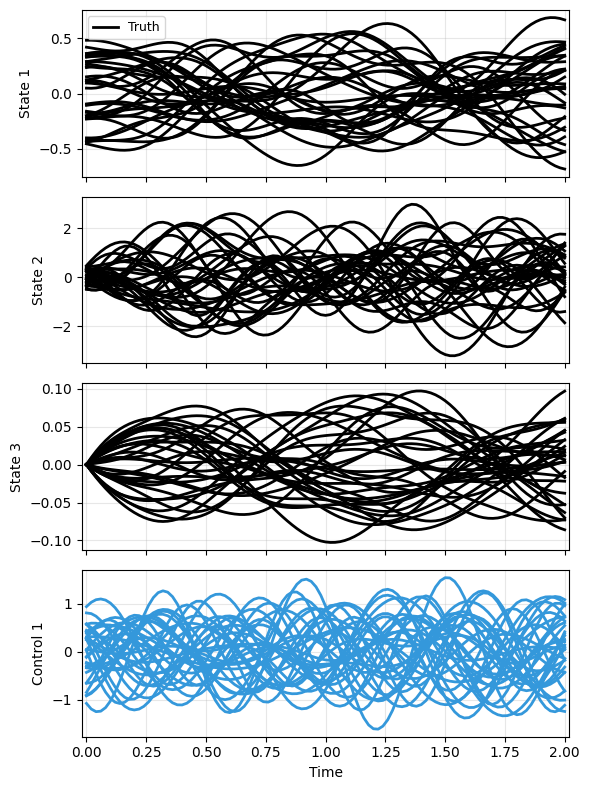

In [4]:
sampler = TrajectorySampler(f, g, config='dyn_data.yaml')
ts, xs, us, ys, ps = sampler.sample(t_grid, batch=B)
np.savez_compressed('data/dyn.npz', t=ts, x=ys, u=us, p=ps)

plot_multi_trajs(np.array([xs]), ts[0], "DP", us=us, labels=['Truth'], ifclose=False)

The configurations for model.  Incremental from the previous part are the options `hidden_layers` and `hidden_dimension`, that define the depth and state dimension of the hidden dynamics.  They are both one, to correspond to the assumed linear form.

Since the hidden states would not be known before training, we need to use NODE training here.

In [ ]:
"""dyn_model.yaml
data:
  path: './data/dyn.npz'
  n_samples: 32
  n_steps: 101
  double_precision: true

transform_x:
  type: "identity"

transform_u:
  type: "identity"

split:
  train_frac: 0.75

dataloader:
  batch_size: 256
"""

In [ ]:
mdl_kl = {
    "name" : 'res_model',
    "encoder_layers" : 1,
    "decoder_layers" : 1,
    "residual_layers" : 1,
    "residual_dimension" : 1,
    "latent_layers" : 1,        # New
    "latent_dimension" : 1,     # New
    "hidden_dimension" : 32,
    "activation" : "none",
    "end_activation" : False,
    "weight_init" : "xavier_uniform",
    "gain" : 0.1,}

trn_nd = {
    "n_epochs": 400,
    "save_interval": 50,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "sweep_lengths": [5, 10],
    "sweep_epoch_step": 200,
    "ode_method": "dopri5",
    "ode_args": {
        "rtol": 1.e-7,
        "atol": 1.e-9}
    }
config_path = 'dyn_model.yaml'

### Creating the model

Similar to the algebraic correction, here we use a `TemplateCorrDif` class to account for hidden dynamics.  Only the physics-based component needs to be defined, and the class handles the rest.

But here we do customize the autoencoder too, to avoid additional need for state estimation.  The encoder needs to estimate $\beta$ from $(x,u)$ (or their history) at the initial condition, and here we just set $\beta=0$ to match the setup in data generation.  The decoder needs to extract the observed states from $z$, which are just the first two elements.

> The state estimation algorithms are under development and will be available soon.

In [ ]:
class DPT(TemplateCorrDif):
    CONT = True
    def base_dynamics(self, x: torch.Tensor, u: torch.Tensor, r: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        # Nearly the same like before.  Using input u this time.
        _f = torch.zeros_like(x)
        _f[..., 0] = x[..., 1]
        _f[..., 1] = - (gg / p[..., 0]) * (torch.sin(x[..., 0]) + r[..., 0] + u[..., 0])
        return _f

    def encoder(self, w) -> torch.Tensor:
        # Used at the initial condition.  Always appending zeros.
        return torch.cat([w.x, torch.zeros(*w.x.shape[:-1], 1, device=w.x.device, dtype=w.x.dtype)], dim=-1)

    def decoder(self, z, w) -> torch.Tensor:
        # z=[x_1, x_2, s], so always taking the first two.
        return z[..., :2]

The JAX version will be the same, and not repeated here.  See the counterpart of this example under `dymad/scripts/pirom_dyn` for more details.

## Training

Nothing fancy here.  Just a bit slower due to more states.

In [ ]:
mdl, MDL, Trainer, opt = 'dp_nd', DPT, NODETrainer, {"model": mdl_kl, "training" : trn_nd}
labels = [mdl]

opt["model"]["name"] = f"dyn_{mdl}"
trainer = Trainer(config_path, MDL, config_mod=opt)
trainer.train()

## Results

In testing, we again try larger range of initial conditions and different parameters.  Furthermore, we try a different type of input.

The prediction is still reasonable.

In [ ]:
"""dyn_test.yaml
dims:
  states: 3
  inputs: 1
  observations: 2
  parameters: 1

x0:
  kind: uniform
  params:
    bounds:
      - [-2.0, 2.0]
      - [-2.0, 2.0]
      - [0, 0]

control:
  kind: gaussian
  params:
    mean: 0.0
    std:  0.5
    t1:   2.0
    dt:   0.2
    mode: zoh

p:
  kind: uniform
  params:
    bounds:
      - [1.0, 5.0]

solver:
  method: RK45
  rtol: 1.0e-6
  atol: 1.0e-6
"""

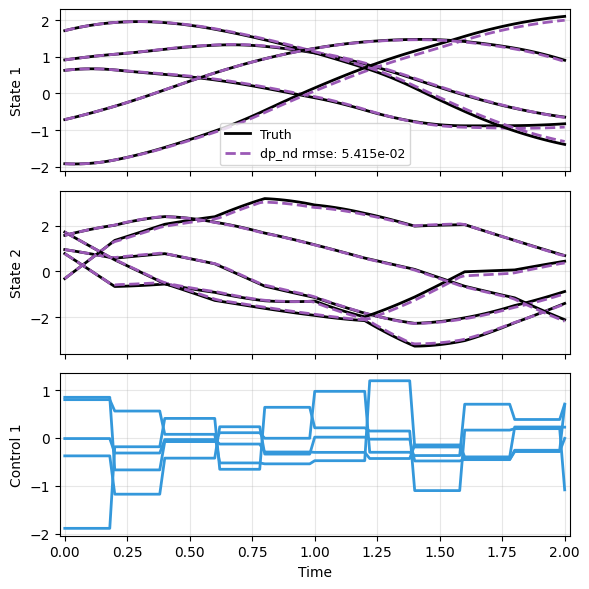

In [10]:
sampler = TrajectorySampler(f, g, config='dyn_test.yaml')
ts, xs, us, ys, ps = sampler.sample(t_grid, batch=5)
x_data = ys
u_data = us
t_data = ts[0]
p_data = ps

_, prd_func = load_model(MDL, f'dyn_{mdl}.pt')
with torch.no_grad():
    pred = prd_func(x_data, t_data, u=u_data, p=p_data)

plot_multi_trajs(
    np.array([x_data, pred]), t_data, "DP", us=u_data,
    labels=['Truth'] + labels, ifclose=False)